# **Detecting COVID-19 Using Chest X-rays**

#### Group 3: Joshua Peterson, Michael Gray and Mangala Desai


---



### Project Initialization & Packages

In [1]:
import os

os.environ['PYTHONHASHSEED']=str(1) #to get reproducible results we have to set this seed before importing tf

def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(1)
   tf.random.set_seed(1)
   np.random.seed(1)
   random.seed(1)

In [ ]:
# Install packages that are needed for this notebook

!pip install importlib_metadata
!pip install image-quality

The following are all the packages needed for this project.

In [3]:
import zipfile
import json
import ast
import cv2
import shutil
import pathlib
import random
import warnings
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import imquality.brisque as brisque
from matplotlib import rcParams, image
from importlib_metadata import metadata
from skimage import draw, io, img_as_float
from sklearn.metrics import classification_report
from tensorflow import keras
from keras import layers
from keras.utils import load_img, image_dataset_from_directory, img_to_array
from PIL import Image
from os.path import isfile, join
from random import shuffle
from sklearn.utils import shuffle
from scipy.stats import ttest_ind
from os import listdir

### Import Dataset to Google Colab

In [4]:
# For use if working from Google Drive

from google.colab import drive

drive.mount('/content/gdrive/')

gdrive_dir = "/content/gdrive/MyDrive/DSBA 6165/Group Project Work/" # This directory reference will need to be updated to wherever the covid-19-chest-x-ray-dataset.zip file is located

if not os.path.exists(gdrive_dir + "covid-19-chest-x-ray-dataset"):
  os.makedirs(gdrive_dir + "covid-19-chest-x-ray-dataset")

Mounted at /content/gdrive/


In [ ]:
zip_ref = zipfile.ZipFile(gdrive_dir + 'covid-19-chest-x-ray-dataset.zip', 'r') # Access the zip file containing the dataset
zip_ref.extractall(gdrive_dir) # Extract dataset from the zip file
zip_ref.close()

In [ ]:
# For use if uploading dataset from local storage

# from google.colab import files

# upload = files.upload()

### Aggregate JSONs

This code aggregates all the individual image JSONs into one JSON file. This will make the JSON information easier to access. **This code does not need to be run if you already have the final *all_jsons.json* file**

In [ ]:
content_dir = '/content/'
directory = gdrive_dir + 'covid-19-chest-x-ray-dataset/releases/all-images/annotations/'

all_dicts = []

for filename in os.listdir(directory): # THIS TAKES A FEW MINUTES ON A LOCAL COMPUTER AND ABOUT A MINUTE ON COLAB
    filepath = directory+filename
    with open(filepath, 'r') as j:
        contents = json.loads(j.read())
        all_dicts.append(contents)

with open(gdrive_dir + 'covid-19-chest-x-ray-dataset/all_jsons.json', 'w') as fout:
    json.dump(all_dicts, fout)

### Removal of Unwanted Images

The following script identifies the images that we would like to exclude from the dataset. **This code does not need to be run if you already have the final *all_jsons.json* file**

In [ ]:
with open(gdrive_dir + 'covid-19-chest-x-ray-dataset/all_jsons.json', 'r') as j: # open the file
    all_jsons = json.loads(j.read())

badfiles = []
for metadatarecord in all_jsons:
    lungcounter = 0
    for a in metadatarecord['annotations']: # loop through annotations list (contains at least 2 lungs, sometimes more stuff)
        if a['name'] == 'Lung': # if the annotation object is for a Lung mask path:
            lungcounter += 1
        else: # if the annotation object is not a Lung mask path, ignore it
            continue
    if lungcounter != 2:
        badfiles.append(metadatarecord['image']['filename'])

with open(gdrive_dir + 'covid-19-chest-x-ray-dataset/badfiles.txt', 'w') as f:
    f.write(str(badfiles))

The following creates an object of the classes within the dataset. **This does not need to be run if you already have the *class_df.pkl* file.**

In [ ]:
filename = gdrive_dir + 'covid-19-chest-x-ray-dataset/all_jsons.json' # file created by running aggregate_jsons.py

with open(filename, 'r') as j: # open the file
    all_jsons = json.loads(j.read())

class_list = ['filename','Bacterial Pneumonia','No Pneumonia (healthy)','Viral Pneumonia','COVID-19','NOS','Fungal Pneumonia','Undefined Pneumonia','Lipoid pneumonia']
# NOS is not a tag used by the dataset, but will be a column we use to tally not-otherwise-specified data
# We've gone ahead and ordered the classes based on their prevalence in the dataset.
# Also added a filename column

zero_data = np.zeros(shape=(len(all_jsons),len(class_list)),dtype=int) # make a 2-d array of zeros
class_df = pd.DataFrame(zero_data, columns=class_list) # pre-populate dataframe with zeros

patient_counter = 0 # initialize patient_counter variable
found_tag = False # initialize flag variable to trag whether we find a tag match

for patient in all_jsons: # loop through each patient dict
    found_tag = False # reset the found_tag flag with each new patient record
    class_df.loc[patient_counter,'filename'] = patient['image']['filename']
    for tag in patient['annotations']:
        if tag['name'] in class_list: # check if tag name matches with our class list
            class_df.loc[patient_counter,tag['name']] = 1 # put a 1 in the relevant column for that patient
            found_tag = True # make the flag true so we don't put a mark in the NOS column

    if found_tag == False: # if we didn't find any tag in the list, mark as NOS
        class_df.loc[patient_counter,'NOS'] = 1

    patient_counter+=1 #increment the counter

# Since all COVID-19 cases are also tagged as Viral Pneumonia, we will 0 the Viral Pneumonia cell for those cases,
# so that the Viral Pneumonia column corresponds to non-COVID Viral Pneumonia:
class_df.loc[class_df['COVID-19']==1,'Viral Pneumonia'] = 0
class_df.rename(columns={'Viral Pneumonia':'Non-COVID Viral Pneumonia'},inplace=True)

class_df.to_pickle(gdrive_dir + 'covid-19-chest-x-ray-dataset/class_df.pkl') # save the dataframe as a pickle for easy re-loading

The following identifies the classes we would like to exclude from the dataset. **This code does not need to be run if you already have the *irrelevant_classes.txt* file.**

In [ ]:
df = pd.read_pickle(gdrive_dir + 'covid-19-chest-x-ray-dataset/class_df.pkl')
index_of_images_to_remove = (df['NOS']==1) | (df['Fungal Pneumonia']==1) | (df['Undefined Pneumonia']==1) | (df['Lipoid pneumonia']==1)
irrelevant_classes = df.loc[index_of_images_to_remove,'filename'].tolist()

with open(gdrive_dir + 'covid-19-chest-x-ray-dataset/irrelevant_classes.txt', 'w') as f:
    f.write(str(irrelevant_classes))

The following script removes xray images that are in non-standard orientations, as well as their corresponding JSON files. After running this script, the **Aggregate JSONs** section should be rerun to create an aggregated JSON that does not contain records with unwanted x-ray orientations.

In [ ]:
with open(gdrive_dir + 'covid-19-chest-x-ray-dataset/badfiles.txt', 'r') as t: # open the file
    badfiles = t.readlines()

badfiles = ast.literal_eval(badfiles[0]) # convert list saved as string back to list

image_dir = content_dir + 'covid-19-chest-x-ray-dataset/images/'
json_dir = content_dir + 'covid-19-chest-x-ray-dataset/releases/all-images/annotations/'

for file in badfiles:
    record_number = file.split('.')[0] # get the record number by splitting from the . in the filename, since the images are of varying file types
    if os.path.isfile(image_dir + file) == True: # check if file exists and then remove if it does
        os.remove(image_dir + file)
    else:
        print('File ' + file + ' did not exist, moving on...')

    if os.path.isfile(json_dir + record_number + '.json') == True:    # check if file exists and then remove if it does
        os.remove(json_dir + record_number + '.json')
    else:
        print('File ' + record_number + '.json' + ' did not exist, moving on...')

The following script removes unwanted classes from the dataset, as well as their corresponding JSON files. After running this script, you should re-run **Aggregate JSONs** to create an aggregated JSON that does not contain records with the unwanted classes.


In [ ]:
with open(gdrive_dir + 'covid-19-chest-x-ray-dataset/irrelevant_classes.txt', 'r') as t: # open the file
    irrelevant_classes = t.readlines()

irrelevant_classes = ast.literal_eval(irrelevant_classes[0]) # convert list saved as string back to list (sorry, probably should have saved the list differently)

image_dir = content_dir + 'covid-19-chest-x-ray-dataset/images/'
json_dir = content_dir + 'covid-19-chest-x-ray-dataset/releases/all-images/annotations/'

for file in irrelevant_classes:
    record_number = file.split('.')[0] # get the record number by splitting from the . in the filename, since the images are of varying file types
    if os.path.isfile(image_dir+file) == True: # check if file exists and then remove if it does
        os.remove(image_dir+file)
    else:
        print('File ' + file + ' did not exist, moving on...')

    if os.path.isfile(json_dir+record_number+'.json') == True:    # check if file exists and then remove if it does
        os.remove(json_dir+record_number+'.json')
    else:
        print('File ' + record_number+'.json' + ' did not exist, moving on...')


Once all unwanted image orientations and classes have been removed, the **Aggregate JSONs** section should be rerun to recompile the *all_jsons.json* file.

### Create Masks for Images

Create a directory to store the masks and masked images.

In [ ]:
mask_img_path = gdrive_dir + 'covid-19-chest-x-ray-dataset/masked_images'
mask_path = gdrive_dir + 'covid-19-chest-x-ray-dataset/masks'

if not os.path.exists(mask_img_path):
  os.makedirs(mask_img_path)

if not os.path.exists(mask_path):
  os.makedirs(mask_path)

Create the image masks.

This code only needs to be run once to initially create the image masks. **If the image masks are already provided, then this code does not need to be run.** This could take around 4 hours to run.

In [ ]:
with open(gdrive_dir + 'covid-19-chest-x-ray-dataset/all_jsons.json', 'r') as j: # open the file
    all_jsons = json.loads(j.read())

def get_imdims(metadatarecord):   # we need to know the width and the height of the image that we're getting mask coordinates for
    img_width = metadatarecord['image']['width']
    img_height = metadatarecord['image']['height']
    return img_width, img_height

def get_maskpath(metadatarecord):   # function to get x and y coordinate paths for lung mask annotations
    lung1_x = [] # initialize lists to append x and y mask path coordinates to
    lung1_y = []
    lung2_x = []
    lung2_y = []
    lungcounter = 0
    for a in metadatarecord['annotations']: # loop through annotations list (contains at least 2 lungs, sometimes more stuff)
        if a['name'] == 'Lung': # if the annotation object is for a Lung mask path:
            lungcounter += 1
            if lungcounter == 1:
                for xy in a['polygon']['path']: # polygon.path contains a list of dictionaries which contain single x and y values
                    lung1_x.append(xy['x']) # append x values to list
                    lung1_y.append(xy['y']) # append y values to list
            elif lungcounter == 2:
                for xy in a['polygon']['path']: # polygon.path contains a list of dictionaries which contain single x and y values
                    lung2_x.append(xy['x']) # append x values to list
                    lung2_y.append(xy['y']) # append y values to list
        else: # if the annotation object is not a Lung mask path, ignore it
            continue

    return lung1_x, lung1_y, lung2_x, lung2_y  #return the x and y coordinate lists for each lung separately

def create_mask(img_height, img_width, y_coords, x_coords):  # function to create masks for each lung: a 2d array where True = lung and False = not lung
    mask = draw.polygon2mask(
        (img_height, img_width),
        np.stack((y_coords, x_coords), axis=1)
    )
    return mask

output_dir = gdrive_dir + 'covid-19-chest-x-ray-dataset/masks/' # directory for saving mask files

for record in all_jsons: # loop through each patient record in the all_jsons file we made (these are metadata records)
    if not os.path.exists(output_dir + record['image']['filename'].split('.')[0]+'_mask.png'):
        img_width, img_height = get_imdims(record)
        lung1_x, lung1_y, lung2_x, lung2_y = get_maskpath(record)
        lung1 = create_mask(img_height, img_width, lung1_y, lung1_x)
        lung2 = create_mask(img_height, img_width, lung2_y, lung2_x)

        lungs_mask = lung1 | lung2 # combining the binary (True/False) masks using the or operator

        # fig, ax = plt.subplots(1, 1)   # can use this in debugging to look at a mask but don't uncomment this when looping through all records
        # ax.imshow(lungs_mask, interpolation='nearest', cmap='gray')
        # plt.show()
        outfile = record['image']['filename'].split('.')[0]+'_mask.png'
        cv2.imwrite(output_dir+outfile, lungs_mask*255) # converts the boolean array implicitly to integer; 0 for false and 1 for true and multiplies by 255 to make it a bit-mask before writing to file

Sample of image mask.

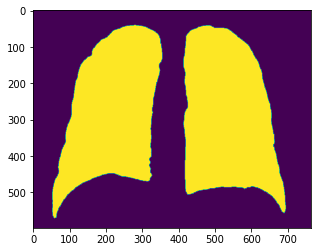

In [ ]:
im = image.imread(gdrive_dir + "covid-19-chest-x-ray-dataset/masks/00000265_mask.png")
plt.imshow(im)
plt.show()

Create masked images. This code only needs to be run once to create the masked images. **If the masked images are already provided, this code does not need to be run.** This could take up to 50 mins to run.

In [ ]:
with open(gdrive_dir + 'covid-19-chest-x-ray-dataset/all_jsons.json', 'r') as j: # open the file
    all_jsons = json.loads(j.read())

content_dir = '/content/'

mask_dir = gdrive_dir + 'covid-19-chest-x-ray-dataset/masks/'
image_dir = gdrive_dir + 'covid-19-chest-x-ray-dataset/images/'
masked_image_dir = gdrive_dir + 'covid-19-chest-x-ray-dataset/masked_images/'

for record in all_jsons:
    record_number = record['image']['filename'].split('.')[0]
    mask_path = mask_dir+record_number+'_mask.png'
    image_path = image_dir+record['image']['filename']
    masked_image_path = masked_image_dir+record_number+'_masked_image.png'
    if os.path.isfile(image_path)==True: # if the image is found in the specified directory the mask png is applied to the image using a bitwise AND operation
        image = cv2.imread(image_path) # reads the image
        mask = cv2.imread(mask_path) # reads the mask image
        masked_image = cv2.bitwise_and(image, mask) # applies the mask to the image
        cv2.imwrite(masked_image_path,masked_image)
    else:
        print('File ' + image_path + ' did not exist, moving on...')

Sample of image with mask applied.

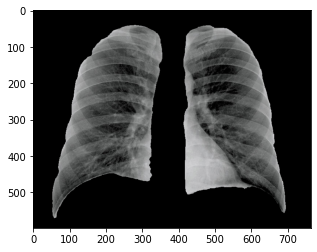

In [ ]:
im_masked = image.imread(gdrive_dir + "covid-19-chest-x-ray-dataset/masked_images/00000265_masked_image.png")
plt.imshow(im_masked)
plt.show()

In [ ]:
lst_masks = os.listdir(gdrive_dir + 'covid-19-chest-x-ray-dataset/masks/') # the directory path
lst_masked_img = os.listdir(gdrive_dir + 'covid-19-chest-x-ray-dataset/masked_images/') # the directory path

len_masks = len(lst_masks)
len_masked_images = len(lst_masked_img)
print(len_masks, len_masked_images)

6287 6293


### Image Preprocessing

Resize masked images. This takes about 15 minutes to run. **This code does not need to be run if the masked images are already resized to 200 x 200.**

In [ ]:
path = gdrive_dir + "covid-19-chest-x-ray-dataset/masked_images/"

im_size = 200 # set the length and width of image

for file in os.listdir(path):
    f_img = path + file
    if os.path.isfile(f_img)==True:
        img = Image.open(f_img) # open image from masked image directory
        img = img.resize((im_size, im_size)) # resize image to the dimensions specified
        img.save(f_img) # save resized image
    else:
        print(file, "did not exist. Moving on...")

Create Brisque score for each image. **This code does not need to be run if you already have the *brisque_scores.csv* file.** This takes up to about 50 minutes to run depending on the size of the images.

In [ ]:
warnings.filterwarnings("ignore", category=FutureWarning) # ignores future warnings that are not needed

path = gdrive_dir + "covid-19-chest-x-ray-dataset/masked_images/"

brisque_scores = [] # initiating an empty list to store brisque scores for each image

for file in os.listdir(path):
    f_img = path + "/" + file
    img = Image.open(f_img); # open image from masked image directory
    b_score = brisque.score(img); # get the brisque score for that image
    append_list = [file, b_score]
    brisque_scores.append(append_list); # append file name and its brisque score to 'brisque_scores' list

In [ ]:
brisque_df = pd.DataFrame(brisque_scores) # create pandas dataframe from brisque_scores list

brisque_df.to_csv(gdrive_dir + 'covid-19-chest-x-ray-dataset/brisque_scores.csv', index=False, header=False) # save brisque_score information for later reference

The following code reads in the calculated brisque score information. **Start here if you already have the *brisque_scores.csv* file.**

In [5]:
brisque_df = pd.read_csv(gdrive_dir + 'covid-19-chest-x-ray-dataset/brisque_scores.csv', header=None)

In [ ]:
len(brisque_df) # the number of x-rays with a calculated brisque score

6287

In [ ]:
brisque_df[:5] # a sample of 5 images and their brisque scores

,0,1
0,00004615_masked_image.png,60.874041
1,00003568_masked_image.png,67.336177
2,00004282_masked_image.png,62.420700
3,00002865_masked_image.png,53.093490
4,00003779_masked_image.png,51.226945


In [ ]:
brisque_df[1].describe()

count    6287.000000
mean       57.041417
std         7.914208
min        22.582087
25%        51.745770
50%        56.985548
75%        62.430678
max        95.258123
Name: 1, dtype: float64

<ipython-input-6-564e8a58a3dd>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


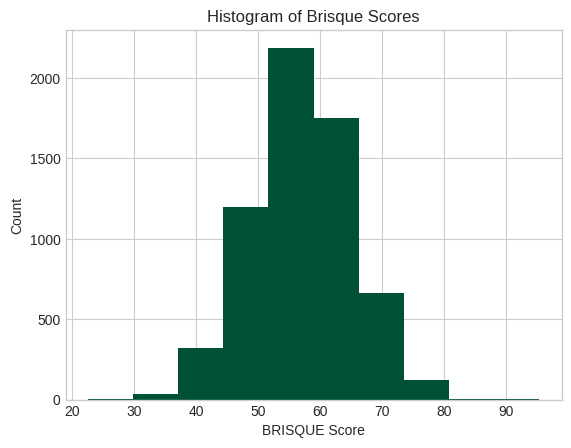

In [6]:
plt.style.use('seaborn-whitegrid')
plt.title("Histogram of Brisque Scores")
plt.xlabel("BRISQUE Score")
plt.ylabel("Count")
brisque_df[1].hist(color="#005035")
plt.show()

Identifying the poor quality images

In [ ]:
low_q_imgs = brisque_df.loc[brisque_df[1] >= 70] # identifies masked images with a brisque score greater than or equal to 70.
low_q_imgs

,0,1
52,00006863_masked_image.png,76.749493
84,00002233_masked_image.png,74.403387
95,00003732_masked_image.png,70.320255
110,00005328_masked_image.png,70.480570
156,00004110_masked_image.png,70.300608
...,...,...
6203,00004054_masked_image.png,71.602131
6223,00006866_masked_image.png,95.258123
6247,00001607_masked_image.png,71.728161
6280,00000828_masked_image.png,73.296855


In [ ]:
low_q_imgs[0]

52      00006863_masked_image.png
84      00002233_masked_image.png
95      00003732_masked_image.png
110     00005328_masked_image.png
156     00004110_masked_image.png
                  ...            
6203    00004054_masked_image.png
6223    00006866_masked_image.png
6247    00001607_masked_image.png
6280    00000828_masked_image.png
6286    00003309_masked_image.png
Name: 0, Length: 314, dtype: object

Removing low quality images from the dataset

In [ ]:
image_dir = gdrive_dir + 'covid-19-chest-x-ray-dataset/masked_images/'
unused_dir = gdrive_dir + 'covid-19-chest-x-ray-dataset/masked_images/unused'

if not os.path.exists(unused_dir):
  os.makedirs(unused_dir)

for file in low_q_imgs[0]:
    if os.path.isfile(image_dir+file) == True: # check if file exists and then remove if it does
        shutil.move(image_dir+file, unused_dir+file)
    else:
        print(file + ' did not exist, moving on...')

### Data Preparation

**This entire *Data Preparation* section of code does not need to be run if the masked images are already located in the *train* and *test* folders.**

Creating the directories

In [ ]:
model_data_dir = gdrive_dir + 'covid-19-chest-x-ray-dataset/masked_images/'

classes = ['bacterial','covid','healthy','viral']

# create the train and test folders
for label in classes:
    if not os.path.exists(model_data_dir + 'train/' + label):
      os.makedirs(model_data_dir + 'train/' + label)

for label in classes:
    if not os.path.exists(model_data_dir + 'test/' + label):
      os.makedirs(model_data_dir + 'test/' + label)

# create the class folders
if not os.path.exists(model_data_dir + 'bacterial'):
    os.makedirs(model_data_dir + 'bacterial')

if not os.path.exists(model_data_dir + 'healthy'):
    os.makedirs(model_data_dir + 'healthy')

if not os.path.exists(model_data_dir + 'viral'):
    os.makedirs(model_data_dir + 'viral')

if not os.path.exists(model_data_dir + 'covid'):
    os.makedirs(model_data_dir + 'covid')

Moving masked images to class folders

In [ ]:
class_df = pd.read_pickle(gdrive_dir + 'covid-19-chest-x-ray-dataset/class_df.pkl')
class_df.drop(columns = ['NOS','Fungal Pneumonia','Undefined Pneumonia','Lipoid pneumonia'],inplace=True)
class_df['No Pneumonia (healthy)'] = class_df['No Pneumonia (healthy)']*2
class_df['Non-COVID Viral Pneumonia'] = class_df['Non-COVID Viral Pneumonia']*3
class_df['COVID-19'] = class_df['COVID-19']*4
class_df['class'] = class_df[['Bacterial Pneumonia','No Pneumonia (healthy)','Non-COVID Viral Pneumonia', 'COVID-19']].sum(axis=1)

# get lists of image filenames for the different classes:
bacterial = class_df['filename'][class_df['class']==1].tolist()
healthy = class_df['filename'][class_df['class']==2].tolist()
viral = class_df['filename'][class_df['class']==3].tolist()
covid = class_df['filename'][class_df['class']==4].tolist()

image_dir = gdrive_dir + 'covid-19-chest-x-ray-dataset/masked_images/'

# move images to the appropriate class folders:
for f in bacterial:
    f = f.split('.')[0]+'_masked_image.png'
    if os.path.isfile(image_dir+f) == True:    # check if file exists and then move to new dir if it does
        shutil.move(image_dir+f, image_dir+'bacterial/'+f)
    else:
        print('File ' + f + ' did not exist, moving on...')

for f in healthy:
    f = f.split('.')[0]+'_masked_image.png'
    if os.path.isfile(image_dir+f) == True:    # check if file exists and then move to new dir if it does
        shutil.move(image_dir+f, image_dir+'healthy/'+f)
    else:
        print('File ' + f + ' did not exist, moving on...')

for f in viral:
    f = f.split('.')[0]+'_masked_image.png'
    if os.path.isfile(image_dir+f) == True:    # check if file exists and then move to new dir if it does
        shutil.move(image_dir+f, image_dir+'viral/'+f)
    else:
        print('File ' + f + ' did not exist, moving on...')

for f in covid:
    f = f.split('.')[0]+'_masked_image.png'
    if os.path.isfile(image_dir+f) == True:    # check if file exists and then move to new dir if it does
        shutil.move(image_dir+f, image_dir+'covid/'+f)
    else:
        print('File ' + f + ' did not exist, moving on...')

Create train and test datasets

In [ ]:
from sklearn.model_selection import train_test_split

image_dir = gdrive_dir + 'covid-19-chest-x-ray-dataset/masked_images/'
classes = ['bacterial','covid','healthy','viral']

for label in classes:
    dir = image_dir + label
    file_list = os.listdir(dir)
    shuffle(file_list)

    train_files, test_files = train_test_split(file_list, test_size=0.3, random_state=1) # creating a train and test split of the masked images

    for file in test_files:
        shutil.move(dir+'/'+file, image_dir+'test/'+label+'/'+file)

    for file in train_files:
        shutil.move(dir+'/'+file, image_dir+'train/'+label+'/'+file)

### Building the Initial Models & Evaluation

Loads in and processes the data to make the train and test datasets. **This code needs to be run before running any of the models in the notebook**

In [5]:
class_names = ['bacterial','healthy','viral','covid']
class_names_label = {class_name:i for i,class_name in enumerate(class_names)}

image_dir = gdrive_dir + 'covid-19-chest-x-ray-dataset/masked_images/'

IMAGE_SIZE = (200,200)
nb_classes = len(class_names)

def load_data():
    image_dir = gdrive_dir + 'covid-19-chest-x-ray-dataset/masked_images'
    CATEGORY = ['train','test']

    output = []

    for category in CATEGORY:
        path = os.path.join(image_dir,category)
        images = []
        labels = []

        print('Loading {}'.format(category))

        for folder in os.listdir(path):
            label = class_names_label[folder]

            for file in os.listdir(os.path.join(path, folder)):
                img_path = os.path.join(os.path.join(path, folder), file)

                image = cv2.imread(img_path)
                image = cv2.resize(image, IMAGE_SIZE)

                images.append(image)
                labels.append(label)

        labels = np.array(labels, dtype = 'int32')
        images = np.array(images, dtype = 'float32')

        output.append((images, labels))

    return output

(train_images, train_labels), (test_images, test_labels) = load_data()
(train_images, train_labels) = shuffle(train_images, train_labels, random_state = 42)

Loading train
Loading test


## Deep Learning Model Development

Loading in the pre-trained ResNet50 model for our image classification task.

In [6]:
class_model_base = keras.applications.ResNet50(
    weights="imagenet",
    include_top=False)

class_model_base.trainable = False

class_model_base.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1_conv[0][0]']          
 on)                      

In [7]:
class_model_base.trainable = True

for layer in class_model_base.layers[:-32]: # making the last layers of the ResNet model trainable - 32 for fine tuned ResNet50
  layer.trainable = False

print("The number of trainable weights in the pretrained model:", len(class_model_base.trainable_weights))


The number of trainable weights in the pretrained model: 40


In [8]:
for i, layer in enumerate(class_model_base.layers):
  if layer.trainable == True: # This prints only the trainable layers of the ResNet50 model base
    print(i, layer.name, "-", layer.trainable) # Prints the trainable layers that will be used for fine-tuning

143 conv5_block1_1_conv - True
144 conv5_block1_1_bn - True
145 conv5_block1_1_relu - True
146 conv5_block1_2_conv - True
147 conv5_block1_2_bn - True
148 conv5_block1_2_relu - True
149 conv5_block1_0_conv - True
150 conv5_block1_3_conv - True
151 conv5_block1_0_bn - True
152 conv5_block1_3_bn - True
153 conv5_block1_add - True
154 conv5_block1_out - True
155 conv5_block2_1_conv - True
156 conv5_block2_1_bn - True
157 conv5_block2_1_relu - True
158 conv5_block2_2_conv - True
159 conv5_block2_2_bn - True
160 conv5_block2_2_relu - True
161 conv5_block2_3_conv - True
162 conv5_block2_3_bn - True
163 conv5_block2_add - True
164 conv5_block2_out - True
165 conv5_block3_1_conv - True
166 conv5_block3_1_bn - True
167 conv5_block3_1_relu - True
168 conv5_block3_2_conv - True
169 conv5_block3_2_bn - True
170 conv5_block3_2_relu - True
171 conv5_block3_3_conv - True
172 conv5_block3_3_bn - True
173 conv5_block3_add - True
174 conv5_block3_out - True


In [9]:
data_augmentation = keras.Sequential(
    [
        layers.RandomRotation(0.1, fill_mode='constant',fill_value=0),
        layers.RandomZoom(0.1),
        layers.RandomTranslation(0.1,0.1,fill_mode='constant',fill_value=0),
    ]
)

inputs = keras.Input(shape=(200, 200, 3))
x = layers.Rescaling(1./255),
x = data_augmentation(inputs)
x = keras.applications.resnet50.preprocess_input(x)
x = class_model_base(x) # using the ResNet pre-trained model as the base for my image classification model
x = layers.Flatten()(x)
x = layers.Dense(512, activation=tf.nn.relu)(x)
x = layers.Dropout(0.2)(x) # Used a dropout rate of 0.2 to regularize the model
outputs = layers.Dense(nb_classes, activation=tf.nn.softmax)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

Creating callbacks and fitting the pre-trained model.

In [10]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="resnet50_im_class_model.ckpt",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(train_images,
                    train_labels,
                    batch_size=128,
                    epochs=20,
                    validation_split = 0.2,
                    callbacks=callbacks)


Epoch 1/20
34/34 [==============================] - 65s 1s/step - loss: 8.7219 - accuracy: 0.5939 - val_loss: 6485.6660 - val_accuracy: 0.2949
Epoch 2/20
34/34 [==============================] - 36s 1s/step - loss: 0.7631 - accuracy: 0.7147 - val_loss: 413.1596 - val_accuracy: 0.3014
Epoch 3/20
34/34 [==============================] - 36s 1s/step - loss: 0.6279 - accuracy: 0.7608 - val_loss: 39.5727 - val_accuracy: 0.3442
Epoch 4/20
34/34 [==============================] - 37s 1s/step - loss: 0.6039 - accuracy: 0.7731 - val_loss: 0.5568 - val_accuracy: 0.7553
Epoch 5/20
34/34 [==============================] - 18s 534ms/step - loss: 0.5198 - accuracy: 0.7992 - val_loss: 0.8523 - val_accuracy: 0.6856
Epoch 6/20
34/34 [==============================] - 38s 1s/step - loss: 0.4811 - accuracy: 0.8099 - val_loss: 0.4773 - val_accuracy: 0.8037
Epoch 7/20
34/34 [==============================] - 19s 559ms/step - loss: 0.4618 - accuracy: 0.8117 - val_loss: 0.4917 - val_accuracy: 0.8019
Epoch 8/

Plotting the loss and accuracy of the pre-trained models.

<ipython-input-11-618991e78b26>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-notebook')
<ipython-input-11-618991e78b26>:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(history.history['accuracy'],'bo-', label='acc', color=train_col)
<ipython-input-11-618991e78b26>:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(history.history['val_accuracy'],'ro--', label='val_acc', color=val_col)
<ipython-input-11-618991e78b26>:19: UserWarning: color is redundantly defined by the 'color' keyword argu

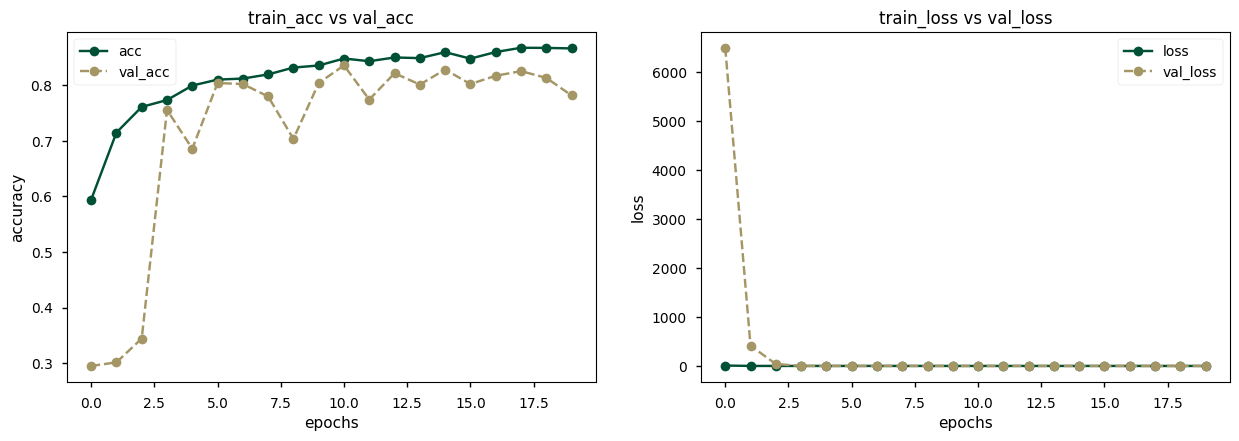

In [11]:
fig = plt.figure(figsize=(15,10))

plt.style.use('seaborn-notebook')

train_col = "#005035"
val_col = "#A49665"

#plot accuracy:
plt.subplot(221)
plt.plot(history.history['accuracy'],'bo-', label='acc', color=train_col)
plt.plot(history.history['val_accuracy'],'ro--', label='val_acc', color=val_col)
plt.title('train_acc vs val_acc')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()

#plot loss
plt.subplot(222)
plt.plot(history.history['loss'],'bo-', label='loss', color=train_col)
plt.plot(history.history['val_loss'],'ro--', label='val_loss', color=val_col)
plt.title('train_loss vs val_loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()

plt.show()

Evaluating the pre-trained models

In [13]:
# Evaluating the model on the test dataset
test_model = keras.models.load_model('resnet50_im_class_model.ckpt')
test_loss, test_acc = test_model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

100/100 [==============================] - 11s 90ms/step - loss: 0.3789 - accuracy: 0.8458
Test accuracy: 0.846


In [15]:
predictions = test_model.predict(test_images)
pred_labels = np.argmax(predictions, axis = 1)
print(classification_report(test_labels, pred_labels))
# 0 = bacterial, 1 = healthy, 2 = viral and 3 = covid

100/100 [==============================] - 9s 82ms/step
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      1405
           1       0.93      0.95      0.94       816
           2       0.69      0.76      0.73       734
           3       0.87      0.99      0.92       223

    accuracy                           0.85      3178
   macro avg       0.84      0.88      0.86      3178
weighted avg       0.85      0.85      0.85      3178



Text(0.5, 1.0, 'ResNet50 Image Classifier Model')

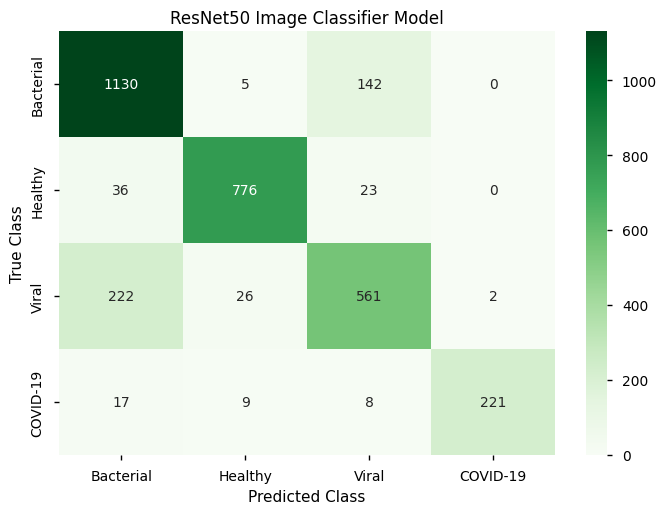

In [16]:
from sklearn.metrics import confusion_matrix

ic_cm = confusion_matrix(pred_labels, test_labels)
sns.heatmap(ic_cm, annot=True, fmt='.0f',xticklabels = ['Bacterial','Healthy','Viral','COVID-19'] , yticklabels = ['Bacterial','Healthy','Viral','COVID-19'], cmap='Greens')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.title('ResNet50 Image Classifier Model')

Saving the weights from the final fine-tuned version of the pre-trained ResNet50 model.

In [ ]:
test_model.save(gdrive_dir + 'covid-19-chest-x-ray-dataset/final_pre-trained_model.h5')